In [ ]:
from utils.helpers import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

### BARRA Risk Model

$$\Sigma = \beta\Omega\beta' + D $$ 

In [3]:
df_beta = pd.read_pickle(r'data/beta.pkl')
df_Sigma_f = pd.read_pickle(r'data/Sigma_f.pkl')
df_Sigma_idio = pd.read_pickle(r'data/Sigma_idio.pkl')

beta = df_beta.values
Sigma_f = df_Sigma_f.values
Sigma_idio = df_Sigma_idio.values

d, m = beta.shape

print('Total number of factors: ', m)
print('Total number of assets: ', d)

Total number of factors:  67
Total number of assets:  500


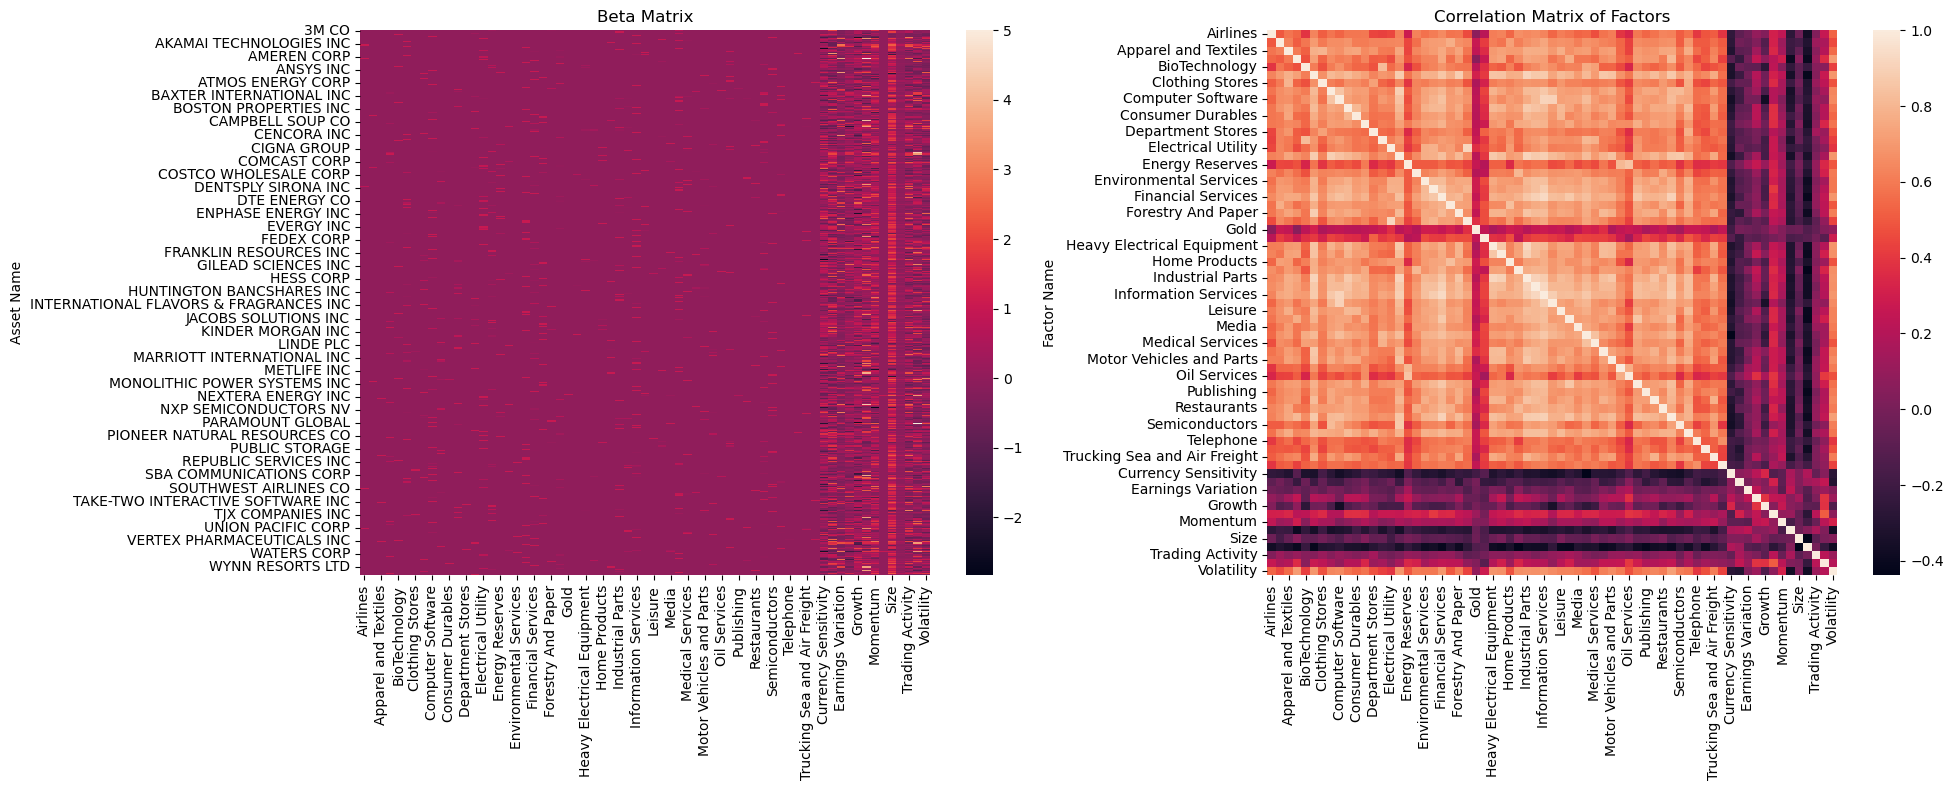

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# First heatmap - df_beta
sns.heatmap(df_beta, ax=axes[0])
axes[0].set_title('Beta Matrix')

# Second heatmap - factor correlation matrix
correlation_matrix = df_Sigma_f/(np.diag(df_Sigma_f)[:,None]@np.diag(df_Sigma_f)[None,:])**.5
sns.heatmap(correlation_matrix, ax=axes[1])
axes[1].set_title('Correlation Matrix of Factors')

plt.tight_layout()

In [5]:
# compute the covariance matrix of the assets
Sigma = beta@Sigma_f@beta.T + Sigma_idio

# inverse matrices (to avoid computation over again, useful for factor risk contributions of a given portfolio)
pseudo_inv_beta = beta@np.linalg.inv(beta.T@beta)
inv_cov = np.linalg.inv(Sigma)
matrix_min_vol = inv_cov@beta@np.linalg.inv(beta.T@inv_cov@beta)

if np.linalg.matrix_rank(beta)!=m:
    raise ValueError('The factor loadings matrix is NOT full rank!')

if is_pos_def(Sigma)==False:
    raise ValueError('The covariance matrix is NOT PSD!')

In [6]:
# compute various risk-based portfolios
theta_ew = np.ones(d)/d
_, theta_erc = compute_risk_budgeting_portfolio(risk_budgets=np.ones(d)/d, cov=Sigma)
theta_mv = compute_minimum_variance_portfolio(cov=Sigma)
theta_mv_long_only = compute_minimum_variance_portfolio(cov=Sigma, long_only=True)
_, theta_factor_erc = compute_factor_risk_budgeting_portfolio(factor_risk_budgets=np.ones(m)/m, betas=beta, cov=Sigma)
_, theta_factor_erc_long_only = compute_factor_risk_budgeting_portfolio(factor_risk_budgets=np.ones(m)/m, betas=beta, cov=Sigma, long_only=True)
_, theta_asset_factor_erc = compute_asset_factor_risk_budgeting_portfolio(asset_risk_budgets=np.ones(d)/d, 
                                                                          factor_risk_budgets=np.ones(m)/m, 
                                                                          asset_importance=.3,
                                                                          factor_importance=.7,
                                                                          betas=beta,
                                                                          cov=Sigma)

theta_nearest_asset_factor_erc, opt_lambda_a = compute_nearest_asset_factor_risk_budgeting_portfolio(asset_risk_budgets=np.ones(d)/d, 
                                                                                   factor_risk_budgets=np.ones(m)/m, 
                                                                                   betas=beta,
                                                                                   cov=Sigma,
                                                                                   n_trials=50)

[I 2025-03-24 16:28:31,768] A new study created in memory with name: no-name-e9eef416-1fe0-47df-98d6-eae71b220f1f
[I 2025-03-24 16:28:32,910] Trial 0 finished with value: 2.356605767176671 and parameters: {'lamdba_a': 0.3941034882376659}. Best is trial 0 with value: 2.356605767176671.
[I 2025-03-24 16:28:33,618] Trial 1 finished with value: 0.8806830871473204 and parameters: {'lamdba_a': 2.920351563859497}. Best is trial 1 with value: 0.8806830871473204.
[I 2025-03-24 16:28:34,745] Trial 2 finished with value: 2.340389390893646 and parameters: {'lamdba_a': 0.3982718698606595}. Best is trial 1 with value: 0.8806830871473204.
[I 2025-03-24 16:28:35,368] Trial 3 finished with value: 0.8822519288795765 and parameters: {'lamdba_a': 2.750752182329398}. Best is trial 1 with value: 0.8806830871473204.
[I 2025-03-24 16:28:36,224] Trial 4 finished with value: 0.9386229758490421 and parameters: {'lamdba_a': 1.8112299025526437}. Best is trial 1 with value: 0.8806830871473204.
[I 2025-03-24 16:28:3

In [7]:
# computed portfolio weights
my_portfolios = np.concatenate(([theta_ew],
                                [theta_erc],
                                [theta_mv],
                                [theta_mv_long_only],
                                [theta_factor_erc],
                                [theta_factor_erc_long_only],
                                [theta_asset_factor_erc],
                                [theta_nearest_asset_factor_erc]
                               ))

pd.DataFrame(my_portfolios, columns=df_beta.index, index=['EW', 'ERC', 'MV', 'MV Long Only', 'Factor ERC', 'Factor ERC Long Only', 'Asset Factor ERC', 'Nearest Asset Factor ERC']).T

,EW,ERC,MV,MV Long Only,Factor ERC,Factor ERC Long Only,Asset Factor ERC,Nearest Asset Factor ERC
Asset Name,,,,,,,,
3M CO,0.002,0.001844,-0.002814,1.705112e-10,0.007315,4.946906e-08,0.001099,0.001611
A. O. SMITH CORP,0.002,0.001764,0.001531,-2.323901e-09,0.018701,1.045440e-02,0.001206,0.001633
ABBOTT LABORATORIES,0.002,0.002615,0.005324,-3.434076e-09,0.001428,1.722958e-08,0.001196,0.001974
ABBVIE INC,0.002,0.003690,0.011483,5.629604e-03,0.024517,1.053928e-08,0.003753,0.003187
ACCENTURE PLC,0.002,0.002469,0.004667,-2.854751e-09,0.019236,-5.544145e-08,0.001001,0.001744
...,...,...,...,...,...,...,...,...
YUM BRANDS INC,0.002,0.002043,-0.003644,-5.914645e-09,-0.000039,3.349379e-09,0.002190,0.002016
ZEBRA TECHNOLOGIES CORP,0.002,0.001420,-0.003619,-1.835609e-09,-0.008748,-1.287436e-07,0.000996,0.001448
ZIMMER BIOMET HOLDINGS INC,0.002,0.001812,-0.001468,-5.568162e-09,0.000683,1.470593e-08,0.000986,0.001594


In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(my_portfolios)

pca_portfolios = pca.transform(my_portfolios)

vol_ew = vol(theta_ew, Sigma)
vol_erc = vol(theta_erc, Sigma)
vol_mv = vol(theta_mv, Sigma)
vol_mv_long_only = vol(theta_mv_long_only, Sigma)
vol_factor_erc = vol(theta_factor_erc, Sigma)
vol_factor_erc_long_only = vol(theta_factor_erc_long_only, Sigma)
vol_asset_factor_erc = vol(theta_asset_factor_erc, Sigma)
vol_nearest_asset_factor_erc = vol(theta_nearest_asset_factor_erc, Sigma)

factor_vol_ew = factor_risk_measure_volatility_analytical(beta.T@theta_ew, matrix_min_vol, Sigma)[0]
factor_vol_erc = factor_risk_measure_volatility_analytical(beta.T@theta_erc, matrix_min_vol, Sigma)[0]
factor_vol_mv = factor_risk_measure_volatility_analytical(beta.T@theta_mv, matrix_min_vol, Sigma)[0]
factor_vol_mv_long_only = factor_risk_measure_volatility_analytical(beta.T@theta_mv_long_only, matrix_min_vol, Sigma)[0]
factor_vol_factor_erc = factor_risk_measure_volatility_analytical(beta.T@theta_factor_erc, matrix_min_vol, Sigma)[0]
factor_vol_erc_long_only = factor_risk_measure_volatility_analytical(beta.T@theta_factor_erc_long_only, matrix_min_vol, Sigma)[0]
factor_vol_asset_factor_erc = factor_risk_measure_volatility_analytical(beta.T@theta_asset_factor_erc, matrix_min_vol, Sigma)[0]
factor_vol_nearest_asset_factor_erc = factor_risk_measure_volatility_analytical(beta.T@theta_nearest_asset_factor_erc, matrix_min_vol, Sigma)[0]

vol_df = pd.DataFrame([vol_ew, vol_erc, vol_mv, vol_mv_long_only, vol_factor_erc,vol_factor_erc_long_only, vol_asset_factor_erc, vol_nearest_asset_factor_erc],
             index = ['$EW$', '$ERC$', '$MV$', '$MV^+$', '$EFRC$', '$EFRC^+$', '$EAFRC$', '$NEAFRC$'],
             columns=['Volatility'])

vol_df['Factor risk'] = [factor_vol_ew, factor_vol_erc, factor_vol_mv,factor_vol_mv_long_only,factor_vol_factor_erc, factor_vol_erc_long_only, factor_vol_asset_factor_erc, factor_vol_nearest_asset_factor_erc]

vol_df['Residual risk'] = vol_df['Volatility'] - vol_df['Factor risk']
(vol_df*100).round(2)

,Volatility,Factor risk,Residual risk
$EW$,19.14,19.14,0.00
$ERC$,17.48,17.48,0.00
$MV$,10.31,10.31,0.00
$MV^+$,12.10,11.91,0.19
$EFRC$,17.95,17.95,0.00
$EFRC^+$,17.88,17.78,0.10
$EAFRC$,17.96,17.95,0.01
$NEAFRC$,18.00,17.99,0.00


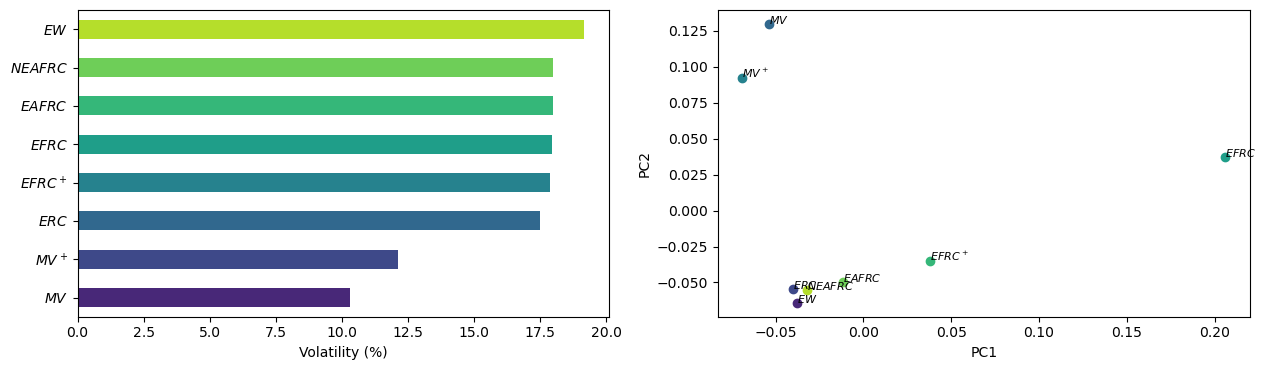

In [9]:
labels = ['$EW$', '$ERC$', '$MV$', '$MV^+$', '$EFRC$', '$EFRC^+$', '$EAFRC$', '$NEAFRC$']

x = pca_portfolios[:,0]
y = pca_portfolios[:,1]

my_palette = sns.color_palette("viridis", 8)

fig, ax = plt.subplots(1,2, figsize=(2*6.4,3.8))

ax[1].scatter(x[0], y[0], marker='o', color=my_palette[0])
ax[1].scatter(x[1], y[1], marker='o', color=my_palette[1])
ax[1].scatter(x[2], y[2], marker='o', color=my_palette[2])
ax[1].scatter(x[3], y[3], marker='o', color=my_palette[3])
ax[1].scatter(x[4], y[4], marker='o', color=my_palette[4])
ax[1].scatter(x[5], y[5], marker='o', color=my_palette[5])
ax[1].scatter(x[6], y[6], marker='o', color=my_palette[6])
ax[1].scatter(x[7], y[7], marker='o', color=my_palette[7])

ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')

ax[1].annotate('$EW$', (x[0],  y[0]), fontsize=8)
ax[1].annotate('$ERC$', (x[1],  y[1]), fontsize=8)
ax[1].annotate('$MV$', (x[2],  y[2]), fontsize=8)
ax[1].annotate('$MV^+$', (x[3],  y[3]), fontsize=8)
ax[1].annotate('$EFRC$', (x[4],  y[4]), fontsize=8)
ax[1].annotate('$EFRC^+$', (x[5],  y[5]), fontsize=8)
ax[1].annotate('$EAFRC$', (x[6],  y[6]), fontsize=8)
ax[1].annotate('$NEAFRC$', (x[7],  y[7]), fontsize=8)

(vol_df['Volatility'].sort_values()*100).plot.barh(ax=ax[0], color=my_palette)
ax[0].set_xlabel('Volatility (%)')
fig.tight_layout()

plt.show()

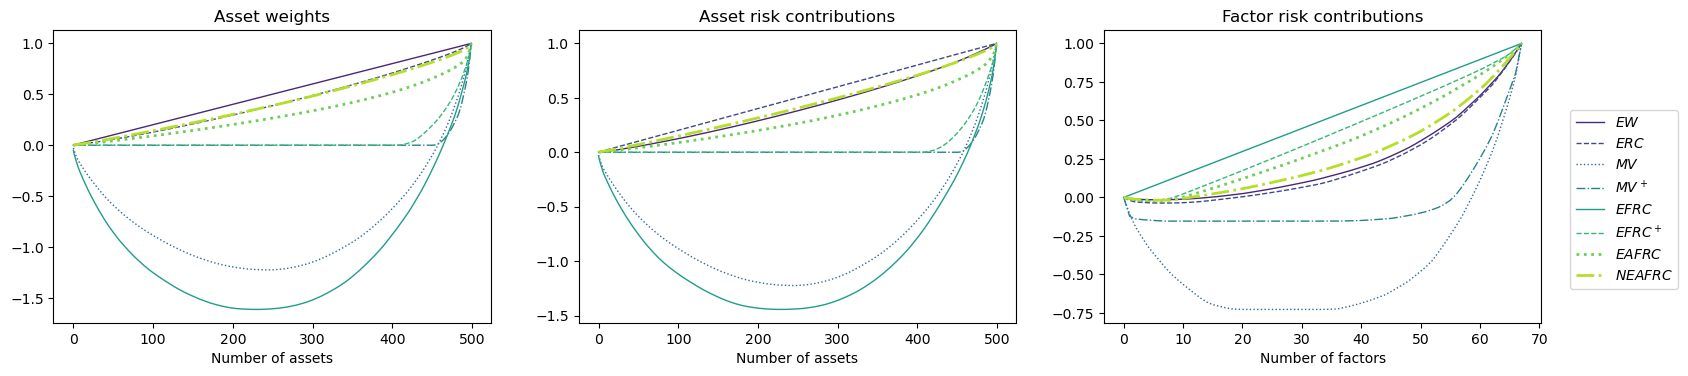

In [10]:
fig, ax = plt.subplots(1,3, figsize=(3*6.4,3.8))

## cumulative sum of sorted asset weights
ax[0].plot(np.cumsum(np.sort(theta_ew)), label='$EW$', linestyle='-', linewidth=1, color=my_palette[0])
ax[0].plot(np.cumsum(np.sort(theta_erc)), label='$ERC$', linestyle='--', linewidth=1, color=my_palette[1])
ax[0].plot(np.cumsum(np.sort(theta_mv)), label='$MV$', linestyle=':', linewidth=1, color=my_palette[2])
ax[0].plot(np.cumsum(np.sort(theta_mv_long_only)), label='$MV^+$', linestyle='-.', linewidth=1, color=my_palette[3])
ax[0].plot(np.cumsum(np.sort(theta_factor_erc)), label='$EFRC$', linestyle='-', linewidth=1, color=my_palette[4])
ax[0].plot(np.cumsum(np.sort(theta_factor_erc_long_only)), label='$EFRC^+$', linestyle='--', linewidth=1, color=my_palette[5])
ax[0].plot(np.cumsum(np.sort(theta_asset_factor_erc)), label='$EAFRC$', linestyle=':', linewidth=2, color=my_palette[6])
ax[0].plot(np.cumsum(np.sort(theta_nearest_asset_factor_erc)), label='$NEAFRC$', linestyle='-.', linewidth=2, color=my_palette[7])

ax[0].set_title('Asset weights', fontsize=12)
ax[0].set_xlabel('Number of assets', fontsize=10)
# ax[0].set_ylim(-.2, 1.1)
## cumulative sum of sorted asset risk contributions

rc_ew = asset_vol_contribution(theta_ew,Sigma)
rc_erc = asset_vol_contribution(theta_erc,Sigma)
rc_mv = asset_vol_contribution(theta_mv,Sigma)
rc_mv_long_only = asset_vol_contribution(theta_mv_long_only,Sigma)
rc_factor_erc = asset_vol_contribution(theta_factor_erc,Sigma)
rc_factor_erc_long_only = asset_vol_contribution(theta_factor_erc_long_only,Sigma)
rc_asset_factor_erc = asset_vol_contribution(theta_asset_factor_erc,Sigma)
rc_nearest_asset_factor_erc = asset_vol_contribution(theta_nearest_asset_factor_erc,Sigma)

pct_rc_ew = rc_ew/sum(rc_ew)
pct_rc_erc = rc_erc/sum(rc_erc)
pct_rc_mv = rc_mv/sum(rc_mv)
pct_rc_mv_long_only = rc_mv_long_only/sum(rc_mv_long_only)
pct_rc_factor_erc = rc_factor_erc/sum(rc_factor_erc)
pct_rc_factor_erc_long_only = rc_factor_erc_long_only/sum(rc_factor_erc_long_only)
pct_rc_asset_factor_erc = rc_asset_factor_erc/sum(rc_asset_factor_erc)
pct_rc_nearest_asset_factor_erc = rc_nearest_asset_factor_erc/sum(rc_nearest_asset_factor_erc)

ax[1].plot(np.cumsum(np.sort(pct_rc_ew)), label='$EW$', linestyle='-', linewidth=1, color=my_palette[0])
ax[1].plot(np.cumsum(np.sort(pct_rc_erc)), label='$ERC$', linestyle='--', linewidth=1, color=my_palette[1])
ax[1].plot(np.cumsum(np.sort(pct_rc_mv)), label='$MV$', linestyle=':', linewidth=1, color=my_palette[2])
ax[1].plot(np.cumsum(np.sort(pct_rc_mv_long_only)), label='$MV^+$', linestyle='-.', linewidth=1, color=my_palette[3])
ax[1].plot(np.cumsum(np.sort(pct_rc_factor_erc)), label='$EFRC$', linestyle='-', linewidth=1, color=my_palette[4])
ax[1].plot(np.cumsum(np.sort(pct_rc_factor_erc_long_only)), label='$EFRC^+$', linestyle='--', linewidth=1, color=my_palette[5])
ax[1].plot(np.cumsum(np.sort(pct_rc_asset_factor_erc)), label='$EAFRC$', linestyle=':', linewidth=2, color=my_palette[6])
ax[1].plot(np.cumsum(np.sort(pct_rc_nearest_asset_factor_erc)), label='$NEAFRC$', linestyle='-.', linewidth=2, color=my_palette[7])
ax[1].set_title('Asset risk contributions', fontsize=12)
ax[1].set_xlabel('Number of assets', fontsize=10)

## cumulative sum of factor risk contributions
w_ew = beta.T@theta_ew
w_erc = beta.T@theta_erc
w_mv = beta.T@theta_mv
w_mv_long_only = beta.T@theta_mv_long_only
w_factor_erc = beta.T@theta_factor_erc
w_factor_erc_long_only = beta.T@theta_factor_erc_long_only
w_asset_factor_erc = beta.T@theta_asset_factor_erc
w_nearest_asset_factor_erc = beta.T@theta_nearest_asset_factor_erc

rc_w_ew = w_ew*grad_factor_risk_measure_volatility_analytical(w_ew, matrix_min_vol, pseudo_inv_beta, Sigma)
rc_w_erc = w_erc*grad_factor_risk_measure_volatility_analytical(w_erc, matrix_min_vol, pseudo_inv_beta, Sigma)
rc_w_mv = w_mv*grad_factor_risk_measure_volatility_analytical(w_mv, matrix_min_vol, pseudo_inv_beta, Sigma)
rc_w_mv_long_only = w_mv_long_only*grad_factor_risk_measure_volatility_analytical(w_mv_long_only, matrix_min_vol, pseudo_inv_beta, Sigma)
rc_w_factor_erc = w_factor_erc*grad_factor_risk_measure_volatility_analytical(w_factor_erc, matrix_min_vol, pseudo_inv_beta, Sigma)
rc_w_factor_erc_long_only = w_factor_erc_long_only*grad_factor_risk_measure_volatility_analytical(w_factor_erc_long_only, matrix_min_vol, pseudo_inv_beta, Sigma)
rc_w_asset_factor_erc = w_asset_factor_erc*grad_factor_risk_measure_volatility_analytical(w_asset_factor_erc, matrix_min_vol, pseudo_inv_beta, Sigma)
rc_w_nearest_asset_factor_erc = w_nearest_asset_factor_erc*grad_factor_risk_measure_volatility_analytical(w_nearest_asset_factor_erc, matrix_min_vol, pseudo_inv_beta, Sigma)

ax[2].plot([0]+list(np.cumsum(np.sort(rc_w_ew/sum(rc_w_ew)))), label='$EW$', linestyle='-', linewidth=1, color=my_palette[0])
ax[2].plot([0]+list(np.cumsum(np.sort(rc_w_erc/sum(rc_w_erc)))), label='$ERC$', linestyle='--', linewidth=1, color=my_palette[1])
ax[2].plot([0]+list(np.cumsum(np.sort(rc_w_mv/sum(rc_w_mv)))), label='$MV$', linestyle=':', linewidth=1, color=my_palette[2])
ax[2].plot([0]+list(np.cumsum(np.sort(rc_w_mv_long_only/sum(rc_w_mv_long_only)))), label='$MV^+$', linestyle='-.', linewidth=1, color=my_palette[3])
ax[2].plot([0]+list(np.cumsum(np.sort(rc_w_factor_erc/sum(rc_w_factor_erc)))), label='$EFRC$', linestyle='-', linewidth=1, color=my_palette[4])
ax[2].plot([0]+list(np.cumsum(np.sort(rc_w_factor_erc_long_only/sum(rc_w_factor_erc_long_only)))), label='$EFRC^+$', linestyle='--', linewidth=1, color=my_palette[5])
ax[2].plot([0]+list(np.cumsum(np.sort(rc_w_asset_factor_erc/sum(rc_w_asset_factor_erc)))), label='$EAFRC$', linestyle=':', linewidth=2, color=my_palette[6])
ax[2].plot([0]+list(np.cumsum(np.sort(rc_w_nearest_asset_factor_erc/sum(rc_w_nearest_asset_factor_erc)))), label='$NEAFRC$', linestyle='-.', linewidth=2, color=my_palette[7])
ax[2].set_title('Factor risk contributions', fontsize=12)

ax[2].set_xlabel('Number of factors', fontsize=10)
ax[2].legend(bbox_to_anchor=(1.05, 0.75))

